In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Masking

Using TensorFlow backend.
C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\silva\AppData\Roa

In [2]:
days = 10

In [3]:
def scale(training_set):
    # Feature Scaling
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    # Creating a data structure with 'days' time-steps and 1 output
    X_train = []
    y_train = []
    for i in range(days, training_set.shape[0]):
        X_train.append(training_set_scaled[i-days:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train, sc

In [4]:
def train_LSTM(X_train, y_train):
    model = Sequential()
    model.add(Masking(mask_value=-1, input_shape = (X_train.shape[1], 1)))
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs = 50, batch_size = 32)
    return model

In [5]:
def predict(dataset_train, dataset_test, model, sc):
    dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
    inputs = dataset_total[len(dataset_total) - dataset_test.shape[0] - days:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(days, inputs.shape[0]):
        X_test.append(inputs[i-days:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print(X_test.shape)
    # (273, 'days', 1)
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    return X_test, predicted_stock_price

In [6]:
def plot_results(dataset_test, predicted_stock_price):
    # Visualising the results
    plt.plot(dataset_test.values, color = 'red', label = 'Real')
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted')
    plt.xticks(np.arange(0,dataset_test.shape[0],50))
    plt.xlabel('Time')
    plt.ylabel('Index')
    plt.legend()
    plt.show()

In [7]:
def impute_with_prediction(df_orig, df_imputed):
    for i in df_orig.index:
        if pd.isna(df_orig.loc[i]):
            df_orig.at[i] = df_imputed.loc[i]
    return df_orig

In [8]:
INPUT = 'output/\CompleteWeeklyIndexes'
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0)

Epoch 1/50
772/772 [==============================] - 7s 9ms/step - loss: 0.0704
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0122
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0047
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0043
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0038
Epoch 13/50
772/772 [====

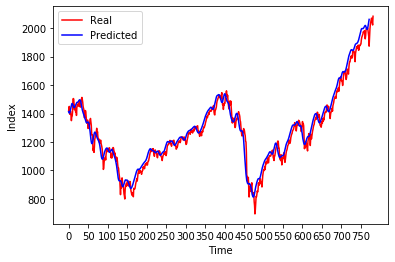

(273, 10, 1)


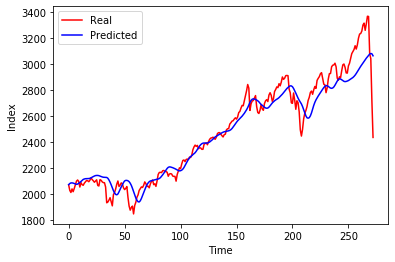

Epoch 1/50
772/772 [==============================] - 6s 8ms/step - loss: 0.0321
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0079
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 5/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 8/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0062
Epoch 12/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 13/50
772/772 [====

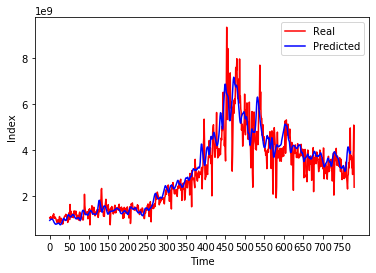

(273, 10, 1)


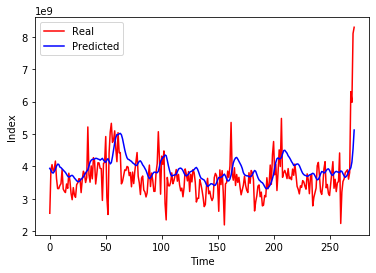

Epoch 1/50
772/772 [==============================] - 7s 9ms/step - loss: 0.0207
Epoch 2/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 3/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0097
Epoch 4/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0085
Epoch 5/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0081
Epoch 6/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 7/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 8/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0068
Epoch 9/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0061
Epoch 10/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0054
Epoch 11/50
772/772 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 12/50
772/772 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 13/50
352/772 [====

In [ ]:
for i in range(0,30):
    df_train_complete = None
    df_test_complete = None
    for col in df.columns:
        test_set = df.loc['2015-01-02':, col].fillna(-1).values #Selecting test data
        training_set = df.loc['2000-01-01':'2015-01-01', col].fillna(-1).values #Selecting training data
        training_set = training_set.reshape(-1, 1)
        X_train, y_train, sc = scale(training_set)
        model = train_LSTM(X_train, y_train)
        # Dados de treinamento
        predicted_stock_price_train = model.predict(X_train)
        predicted_stock_price_train = sc.inverse_transform(predicted_stock_price_train)
        plot_results(df.loc['2000-01-01':'2015-01-01', col].fillna(-1), predicted_stock_price_train)
        # Dados de teste
        X_test, predicted_stock_price = predict(df.loc['2000-01-01':'2015-01-01', col].fillna(-1), df.loc['2015-01-02':, col].fillna(-1), model, sc)
        plot_results(df.loc['2015-01-02':, col].fillna(-1), predicted_stock_price)

        vazio = np.empty(days)
        predicted_stock_price_train = np.append(vazio, predicted_stock_price_train)
        series_complete_train = impute_with_prediction(df.loc['2000-01-01':'2015-01-01', col], pd.DataFrame(index=df.loc['2000-01-01':'2015-01-01', col].index, data=predicted_stock_price_train))
        df_train_complete = pd.concat([df_train_complete, pd.DataFrame(index=df.loc['2000-01-01':'2015-01-01', col].index, data=series_complete_train, columns=[col])], axis=1, join='outer')
        df_test_complete = pd.concat([df_test_complete, pd.DataFrame(data=predicted_stock_price, index = df.loc['2015-01-02':, col].index, columns = [col])], axis=1, join='outer')
        df_train_complete.to_csv(r'output\/CompleteIndexesWeeklyTrainLSTM10_'+str(i)+'.csv', index = True)
        df_test_complete.to_csv(r'output\/CompleteIndexesWeeklyTestLSTM10_'+str(i)+'.csv', index = True)